# 연습문제: LSTM 모델 성능 향상시키기

### 문제 1

예나(Jena) 도시의 날씨 데이터를 활용하여 LSTM 또는 GRU 모델을 구현한 후
성능을 최대한 끌어올리는 과정을 묘사하라.

- 층의 유닛 개수 및 드랍아웃 비율 조정
- RMSprop 등의 옵티마이저의 학습률 조정 및 다른 옵티마이저 활용
- 순환층 이후에 여러 개의 밀집층 적용
- 시퀀스 길이 조정, 샘플 선택 비율 조정 등 기타 특성 엔지니어링 시도.

**참고**: [10장 시계열 데이터와 순환 신경망](https://codingalzi.github.io/dlp/notebooks/dlp10_dl_for_timeseries.html)

**힌트**: `recurrent_dropout` 옵션을 사용할 경우 `unroll=True` 옵션을 함께
활용해야 GPU를 활용할 수 있다. 
하나의 시퀀스 길이가 100 이하로 지정되어야 함에 주의하라.

### 데이터셋 준비

독일 예나(Jena)시에 위치한 막스-플랑크(Max-Planck) 생지화확(Biogeochemistry) 연구소가
수 년동안 온도, 기압, 풍향 등 14 종류의 기상 데이터를 10분 단위로 측정해서 수집한 데이터셋이다. 
원래 2003년부터 측정하였지만 여기서는 2009-2016년 데이터만 이용한다. 

**zip 파일 다운로드 및 압축풀기**

"jena_climate_2009_2016.csv" 파일이 생성된다.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip
else: 
    try: 
        import wget, zipfile
    except ModuleNotFoundError: 
        !pip install wget
        
    import wget, zipfile
    wget.download('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip')
    with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

--2021-11-30 07:04:34--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12.94M  45.4MB/s    in 0.3s    

2021-11-30 07:04:34 (45.4 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**예나(Jena) 날씨 데이터셋 살펴보기**

파일을 열어 줄(line) 단위로 쪼갠다.

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")

첫째 줄은 날짜와 시간 이외에 14개의 특성명이 쉼표(콤마)로 구분되어 있으며,
총 420,451개의 데이터를 포함한다.

In [ ]:
header = lines[0].split(",")
lines = lines[1:]

In [ ]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [ ]:
print(len(lines))

420451


**넘파이 어레이로 변환**

In [ ]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]

    temperature[i] = values[1]    # i 번째 온도
    raw_data[i, :] = values[:]    # i 번째 데이터

**온도 변화 그래프**

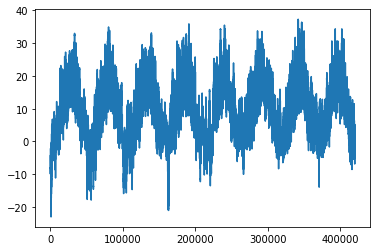

In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

**처음 10일동안의 온도 변화**

한 시간에 6번, 하루 24시간, 10일동안 측정 횟수는 `6 * 24 * 10 = 1,440`이다.

- 1월 1일 - 1월 10일 기간동안 측정된 온도라 상당히 낮다.
- 마지막 4일 동안은 일 단위 온도 변화가 주기성을 띈다. 

**주기성**(periodicity)은 시계열 데이터의 기본 특성 중 하나이다.
월별 주기성은 매우 일관성을 갖는다. 
지난 몇 달동안의 데이터를 이용하여 다음 달의 평균 온도를 예측하는 일은 상대적으로 쉽다.
반면에 일 단위의 예측은 아래 그래프에서 보듯이 훨씬 혼잡하다. 

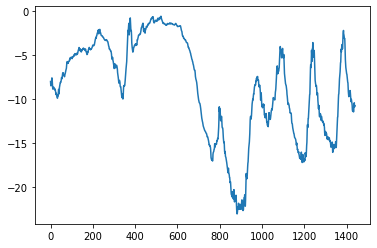

In [ ]:
plt.plot(range(1440), temperature[:1440])

**훈련셋, 검증셋, 테스트셋 크기**

- 훈련셋: 전체의 50%
- 검증셋: 전체의 25%
- 테스트셋: 전체의 25%

미래에 대한 예측을 실행하므로 훈련셋, 검증셋, 테스트셋 순으로 
보다 오래된 데이터를 사용한다. 

In [ ]:
num_train_samples = int(0.5 * len(raw_data))     # 전체의 50%
num_val_samples   = int(0.25 * len(raw_data))    # 전체의 25%
num_test_samples  = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:\t", num_train_samples)
print("num_val_samples:\t", num_val_samples)
print("num_test_samples:\t", num_test_samples)

num_train_samples:	 210225
num_val_samples:	 105112
num_test_samples:	 105114


### 데이터 전처리(sequence_length = 90 설정)

**데이터 정규화**

In [ ]:
# 훈련셋의 평균
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

# 훈련셋의 표준편차
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**3.75일 단위 시퀀스 데이터 준비**

In [ ]:
from tensorflow import keras

# 1시간에 하나의 데이터 선택
sampling_rate = 6

# 입력 데이터 시퀀스: 지난 3.75일치(90시간) 온도 데이터
sequence_length = 90

# 타깃 설정:24시간 이후의 온도. 지연(delay)을 6일치로 지정
delay = sampling_rate * (sequence_length + 24 - 1)

# 배치 크기
batch_size = 256

# 훈련셋
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # 생성된 시퀀스들의 순서 무작위화
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# 검증셋
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# 테스트셋
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

생성된 새로운 데이터셋은 훈련셋의 샘플과 타깃을 함께 배치 단위로 묶여있다.
예를 들어, 훈련셋의 첫째 배치의 모양은 다음과 같다.

- 배치 크기: 256
- 시퀀스 샘플 모양: `(90, 14)`
    - 14개의 특성을 갖는 날씨 데이터 5일치

<u>**`recurrent_dropout` 옵션을 사용하기 때문에 GPU를 활용하기 위해 `unroll=True` 옵션을 함께 활용했다.**</u>

<u>**하나의 시퀀스 길이가 100 이하로 지정되어야해서 시퀀스 샘플 모양을 120에서 90으로 축소했다.**</u>

In [ ]:
for samples, targets in train_dataset:
    print("샘플 모양:", samples.shape)
    print("타깃 모양:", targets.shape)
    break

샘플 모양: (256, 90, 14)
타깃 모양: (256,)


케라스 텐서플로 레이어 불러오기

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

### 기본 모델 (Test MAE: 2.64)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# 모델 구성
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs) # 1차원 데이터로 변환하기
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

# 모델 컴파일 및 실행
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# 최선 모델 활용
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 9ms/step - loss: 12.2736 - mae: 2.7183 - val_loss: 10.8664 - val_mae: 2.6009
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.0685 - mae: 2.3677 - val_loss: 9.8934 - val_mae: 2.4891
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.3427 - mae: 2.2740 - val_loss: 10.3937 - val_mae: 2.5519
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 7.8283 - mae: 2.2023 - val_loss: 10.3538 - val_mae: 2.5459
Epoch 5/10
819/819 [==============================] - 8s 9ms/step - loss: 7.4707 - mae: 2.1519 - val_loss: 10.5405 - val_mae: 2.5723
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.2358 - mae: 2.1186 - val_loss: 11.3723 - val_mae: 2.6761
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 7.0119 - mae: 2.0874 - val_loss: 11.4496 - val_mae: 2.6884
Epoch 8/10
819/819 [==============================] - 7s 9ms/step - l

## 순환 신경망(LSTM 층 사용) 활용

### 순환 드랍아웃 적용

- 매 타임스텝에 대해 동일한 드랍아웃 마스크 적용
- 두 종류의 드랍아웃 옵션 사용
    - `dropout`: 층의 입력값에 대한 드랍아웃 비율 지정
    - `recurrent_dropout`: 순환 유닛에 대한 드랍아웃 비율 지정

 `unroll=True` 옵션을 데이터 전처리 과정에서 활용하였다.
 
 나머지 옵션을 조정해서 성능을 높여보자.

- 층의 유닛 개수 및 드랍아웃 비율 조정
- RMSprop 등의 옵티마이저의 학습률 조정 및 다른 옵티마이저 활용
- 순환층 이후에 여러 개의 밀집층 적용
- 시퀀스 길이 조정, 샘플 선택 비율 조정 등 기타 특성 엔지니어링 시도.

### 수정 모델 #1 (Test MAE: 2.46)

```python
# 1
# 층의 유닛 개수 수정
x = layers.LSTM(64, recurrent_dropout=0.25, unroll=True)(inputs)

# 드랍아웃 비율 조정
x = layers.Dropout(0.55)(x)

# 밀집층 10 적용
outputs = layers.Dense(10)(x)

# 다른 옵티마이저 활용
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(64, recurrent_dropout=0.25, unroll=True)(inputs)
x = layers.Dropout(0.55)(x)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
820/820 [==============================] - 215s 217ms/step - loss: 30.5354 - mae: 4.0310 - val_loss: 10.1122 - val_mae: 2.4482
Epoch 2/10
820/820 [==============================] - 175s 212ms/step - loss: 14.1382 - mae: 2.9263 - val_loss: 9.2992 - val_mae: 2.3715
Epoch 3/10
820/820 [==============================] - 174s 212ms/step - loss: 13.0873 - mae: 2.8126 - val_loss: 8.8958 - val_mae: 2.3224
Epoch 4/10
820/820 [==============================] - 175s 213ms/step - loss: 12.4955 - mae: 2.7501 - val_loss: 8.7884 - val_mae: 2.3060
Epoch 5/10
820/820 [==============================] - 174s 212ms/step - loss: 12.0679 - mae: 2.6998 - val_loss: 8.8510 - val_mae: 2.3085
Epoch 6/10
820/820 [==============================] - 173s 210ms/step - loss: 11.7286 - mae: 2.6616 - val_loss: 8.6372 - val_mae: 2.2815
Epoch 7/10
820/820 [==============================] - 173s 210ms/step - loss: 11.3743 - mae: 2.6219 - val_loss: 8.7024 - val_mae: 2.2934
Epoch 8/10
820/820 [====================

### 수정 모델 #2 (Test MAE: 2.49)

```python
# 2
# 층의 유닛 개수 수정
x = layers.LSTM(64, recurrent_dropout=0.20, unroll=True)(inputs)

# 드랍아웃 비율 조정
x = layers.Dropout(0.4)(x)

# 밀집층 5 적용
outputs = layers.Dense(5)(x)

# 다른 옵티마이저 활용
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(64, recurrent_dropout=0.20, unroll=True)(inputs)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(5)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
820/820 [==============================] - 260s 263ms/step - loss: 27.2209 - mae: 3.7886 - val_loss: 10.4186 - val_mae: 2.4926
Epoch 2/10
820/820 [==============================] - 213s 259ms/step - loss: 12.5049 - mae: 2.7579 - val_loss: 9.0695 - val_mae: 2.3386
Epoch 3/10
820/820 [==============================] - 211s 257ms/step - loss: 11.5209 - mae: 2.6436 - val_loss: 8.8693 - val_mae: 2.3026
Epoch 4/10
820/820 [==============================] - 209s 254ms/step - loss: 10.7771 - mae: 2.5589 - val_loss: 8.8376 - val_mae: 2.3115
Epoch 5/10
820/820 [==============================] - 211s 257ms/step - loss: 10.2678 - mae: 2.4944 - val_loss: 9.0877 - val_mae: 2.3451
Epoch 6/10
820/820 [==============================] - 207s 252ms/step - loss: 9.8268 - mae: 2.4396 - val_loss: 9.0177 - val_mae: 2.3406
Epoch 7/10
820/820 [==============================] - 208s 253ms/step - loss: 9.4450 - mae: 2.3896 - val_loss: 9.1976 - val_mae: 2.3600
Epoch 8/10
820/820 [======================

### 수정 모델 #3 (Test MAE: 2.46)

```python
# 3
# 층의 유닛 개수 수정
x = layers.LSTM(64, recurrent_dropout=0.20, unroll=True)(inputs)

# 드랍아웃 비율 조정
x = layers.Dropout(0.4)(x)

# 밀집층 5 적용
outputs = layers.Dense(5)(x)

# 다른 옵티마이저 활용
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

# 훈련 횟수 20회
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(128, recurrent_dropout=0.3, unroll=True)(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
820/820 [==============================] - 243s 249ms/step - loss: 13.4340 - mae: 2.7978 - val_loss: 9.0227 - val_mae: 2.3316
Epoch 2/20
820/820 [==============================] - 199s 243ms/step - loss: 10.0523 - mae: 2.4786 - val_loss: 8.6688 - val_mae: 2.2955
Epoch 3/20
820/820 [==============================] - 201s 244ms/step - loss: 9.0563 - mae: 2.3514 - val_loss: 9.1955 - val_mae: 2.3712
Epoch 4/20
820/820 [==============================] - 201s 244ms/step - loss: 8.2593 - mae: 2.2461 - val_loss: 9.2553 - val_mae: 2.3781
Epoch 5/20
820/820 [==============================] - 196s 238ms/step - loss: 7.6326 - mae: 2.1572 - val_loss: 9.3069 - val_mae: 2.3887
Epoch 6/20
820/820 [==============================] - 192s 234ms/step - loss: 7.1110 - mae: 2.0791 - val_loss: 10.0833 - val_mae: 2.4815
Epoch 7/20
820/820 [==============================] - 196s 239ms/step - loss: 6.6963 - mae: 2.0147 - val_loss: 10.1433 - val_mae: 2.5029
Epoch 8/20
820/820 [========================

### 수정 모델 #4 (Test MAE: 2.45)

```python
# 4
# 층의 개수 및 유닛 개수 수정
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)

# 드랍아웃 비율 조정
x = layers.Dropout(0.25)(x)

# 훈련 횟수 20회
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
820/820 [==============================] - 241s 247ms/step - loss: 17.2851 - mae: 3.1106 - val_loss: 9.1252 - val_mae: 2.3537
Epoch 2/20
820/820 [==============================] - 199s 242ms/step - loss: 11.2485 - mae: 2.6169 - val_loss: 8.9193 - val_mae: 2.3179
Epoch 3/20
820/820 [==============================] - 200s 243ms/step - loss: 10.6177 - mae: 2.5438 - val_loss: 8.8827 - val_mae: 2.3118
Epoch 4/20
820/820 [==============================] - 199s 242ms/step - loss: 10.2006 - mae: 2.4920 - val_loss: 8.6916 - val_mae: 2.2851
Epoch 5/20
820/820 [==============================] - 199s 242ms/step - loss: 9.8782 - mae: 2.4539 - val_loss: 8.8614 - val_mae: 2.3075
Epoch 6/20
820/820 [==============================] - 198s 241ms/step - loss: 9.6093 - mae: 2.4190 - val_loss: 8.7432 - val_mae: 2.2894
Epoch 7/20
820/820 [==============================] - 201s 245ms/step - loss: 9.3435 - mae: 2.3849 - val_loss: 8.9472 - val_mae: 2.3166
Epoch 8/20
820/820 [========================

### 수정 모델 #5 (Test MAE: 2.48)

```python
# 5
# 층의 유닛 개수 수정
x = layers.LSTM(64, recurrent_dropout=0.25, unroll=True)(inputs)

# 드랍아웃 비율 조정
x = layers.Dropout(0.55)(x)

# 밀집층 10 적용
outputs = layers.Dense(10)(x)

# 다른 옵티마이저 활용
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

# 훈련 횟수 20회
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(64, recurrent_dropout=0.25, unroll=True)(inputs)
x = layers.Dropout(0.55)(x)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
820/820 [==============================] - 208s 208ms/step - loss: 32.2119 - mae: 4.1567 - val_loss: 10.2547 - val_mae: 2.4728
Epoch 2/20
820/820 [==============================] - 166s 202ms/step - loss: 14.3648 - mae: 2.9523 - val_loss: 9.4498 - val_mae: 2.3931
Epoch 3/20
820/820 [==============================] - 164s 200ms/step - loss: 13.3509 - mae: 2.8453 - val_loss: 9.0502 - val_mae: 2.3428
Epoch 4/20
820/820 [==============================] - 163s 198ms/step - loss: 12.9355 - mae: 2.7964 - val_loss: 8.9083 - val_mae: 2.3170
Epoch 5/20
820/820 [==============================] - 162s 198ms/step - loss: 12.4427 - mae: 2.7454 - val_loss: 8.7995 - val_mae: 2.3010
Epoch 6/20
820/820 [==============================] - 166s 202ms/step - loss: 12.0045 - mae: 2.6939 - val_loss: 8.7202 - val_mae: 2.2895
Epoch 7/20
820/820 [==============================] - 166s 202ms/step - loss: 11.6539 - mae: 2.6512 - val_loss: 8.7853 - val_mae: 2.2981
Epoch 8/20
820/820 [====================

### 수정 모델 #6 (Test MAE: 2.43)

```python
# 6 (재실행해서 2.46인데 2.43이었습니다.)
# 층의 개수 및 유닛 개수 수정
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)

x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)

# 훈련 횟수 20회
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.Dropout(0.25)(x)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
820/820 [==============================] - 210s 213ms/step - loss: 17.0060 - mae: 3.0861 - val_loss: 9.5989 - val_mae: 2.4239
Epoch 2/20
820/820 [==============================] - 170s 207ms/step - loss: 11.2641 - mae: 2.6191 - val_loss: 9.0438 - val_mae: 2.3317
Epoch 3/20
820/820 [==============================] - 169s 206ms/step - loss: 10.7238 - mae: 2.5551 - val_loss: 8.7653 - val_mae: 2.2955
Epoch 4/20
820/820 [==============================] - 171s 208ms/step - loss: 10.3537 - mae: 2.5097 - val_loss: 9.0087 - val_mae: 2.3198
Epoch 5/20
820/820 [==============================] - 171s 208ms/step - loss: 10.0270 - mae: 2.4715 - val_loss: 8.6738 - val_mae: 2.2723
Epoch 6/20
820/820 [==============================] - 171s 208ms/step - loss: 9.7874 - mae: 2.4412 - val_loss: 8.5969 - val_mae: 2.2676
Epoch 7/20
820/820 [==============================] - 172s 209ms/step - loss: 9.5036 - mae: 2.4066 - val_loss: 8.5763 - val_mae: 2.2662
Epoch 8/20
820/820 [=======================

## 데이터 전처리 과정을 새로 거친 후 수정 모델 적용

### 데이터 전처리(sequence_length = 360, sampling_rate = 3 설정)

**데이터 정규화**

In [ ]:
# 훈련셋의 평균
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

# 훈련셋의 표준편차
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**15일 단위 시퀀스 데이터 준비**

In [ ]:
from tensorflow import keras

# 30분에 하나의 데이터 선택
sampling_rate = 3

# 입력 데이터 시퀀스: 지난 15일치(360시간) 온도 데이터
sequence_length = 360

# 타깃 설정:24시간 이후의 온도. 지연(delay)을 6일치로 지정
delay = sampling_rate * (sequence_length + 24 - 1)

# 배치 크기
batch_size = 256

# 훈련셋
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # 생성된 시퀀스들의 순서 무작위화
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# 검증셋
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# 테스트셋
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
    print("샘플 모양:", samples.shape)
    print("타깃 모양:", targets.shape)
    break

샘플 모양: (256, 360, 14)
타깃 모양: (256,)


케라스 텐서플로 레이어 불러오기

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

### 수정 모델 #7 (Test MAE: 2.09)

```python
# 7
# 층의 개수 및 유닛 개수 수정
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)

x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)

# 훈련 횟수 20회
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.Dropout(0.25)(x)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5, unroll=True)(inputs)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
817/817 [==============================] - 746s 713ms/step - loss: 17.9337 - mae: 3.1892 - val_loss: 8.6676 - val_mae: 2.3040
Epoch 2/20
817/817 [==============================] - 565s 691ms/step - loss: 10.1384 - mae: 2.4876 - val_loss: 8.0794 - val_mae: 2.2282
Epoch 3/20
817/817 [==============================] - 563s 689ms/step - loss: 9.0607 - mae: 2.3574 - val_loss: 7.1462 - val_mae: 2.0869
Epoch 4/20
817/817 [==============================] - 569s 696ms/step - loss: 8.4651 - mae: 2.2793 - val_loss: 7.4343 - val_mae: 2.1230
Epoch 5/20
817/817 [==============================] - 564s 690ms/step - loss: 8.1130 - mae: 2.2305 - val_loss: 7.1148 - val_mae: 2.0817
Epoch 6/20
817/817 [==============================] - 560s 685ms/step - loss: 7.8196 - mae: 2.1905 - val_loss: 6.8740 - val_mae: 2.0370
Epoch 7/20
817/817 [==============================] - 557s 682ms/step - loss: 7.6288 - mae: 2.1629 - val_loss: 6.6709 - val_mae: 2.0097
Epoch 8/20
817/817 [==========================

### 수정 모델 #8 (Test MAE: 2.09)

```python
# 6
# 층의 개수 및 유닛 개수 수정
x = layers.LSTM(32, recurrent_dropout=0.1, unroll=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.1, unroll=True)(inputs)

x = layers.LSTM(64, recurrent_dropout=0.1, unroll=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.1, unroll=True)(inputs)

# 드랍아웃 비율 조정
x = layers.Dropout(0.1)(x)

# 훈련 횟수 20회
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
```

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32, recurrent_dropout=0.1, unroll=True)(inputs)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
817/817 [==============================] - 568s 413ms/step - loss: 25.5005 - mae: 3.6443 - val_loss: 7.9981 - val_mae: 2.2072
Epoch 2/20
817/817 [==============================] - 318s 388ms/step - loss: 8.9044 - mae: 2.3389 - val_loss: 6.9073 - val_mae: 2.0600
Epoch 3/20
817/817 [==============================] - 315s 385ms/step - loss: 7.8028 - mae: 2.1906 - val_loss: 6.6270 - val_mae: 2.0248
Epoch 4/20
817/817 [==============================] - 322s 394ms/step - loss: 7.2851 - mae: 2.1178 - val_loss: 6.4709 - val_mae: 2.0120
Epoch 5/20
817/817 [==============================] - 315s 386ms/step - loss: 6.9185 - mae: 2.0610 - val_loss: 6.3252 - val_mae: 1.9807
Epoch 6/20
817/817 [==============================] - 316s 386ms/step - loss: 6.6560 - mae: 2.0223 - val_loss: 6.5390 - val_mae: 2.0113
Epoch 7/20
817/817 [==============================] - 319s 390ms/step - loss: 6.4804 - mae: 1.9932 - val_loss: 6.4443 - val_mae: 2.0059
Epoch 8/20
817/817 [===========================